###**Implementación en TensorFlow/Keras**

####**Importación de Librerías**

Se importaron las siguientes librerias, entre ellas `tensorflow`, `keras` y `cifar10` para construir y entrenar el modelo.

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


###**Carga del Conjunto de Datos CIFAR-10**

El conjunto de datos se redimensionó y normalizó para adaptarse a la entrada de AlexNet.

In [22]:
# Cargar CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalizar imágenes (0-1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Convertir etiquetas a one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

# 🔹 Crear dataset con resize en tiempo real
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Redimensionar en tiempo real
    #image = data_augmentation(image)  # Aplicar data augmentation
    return image, label

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot))
test_dataset = test_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

* **Redimensionamiento**: Las imágenes se redimensionan a 224x224 píxeles, que es el tamaño de entrada esperado por AlexNet.

* **Dataset**: Se crean conjuntos de datos (`train_dataset` y `test_dataset`) que aplican el preprocesamiento y el aumento de datos en tiempo real.

* **Prefetching**: Se utiliza `prefetch` para optimizar el rendimiento durante el entrenamiento.

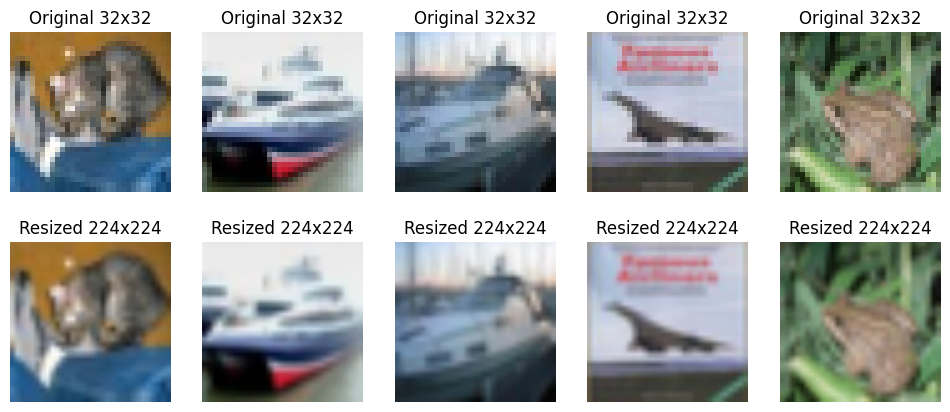

In [23]:
# 🔹 Función para mostrar imágenes antes y después del resize
def show_images_before_after_resize(x_original, x_resized, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 5))

    for i in range(num_images):
        # Imagen original (32x32)
        axes[0, i].imshow(x_original[i])
        axes[0, i].axis("off")
        axes[0, i].set_title("Original 32x32")

        # Imagen redimensionada (224x224)
        resized_img = tf.image.resize(x_original[i], (224, 224)).numpy()
        axes[1, i].imshow(resized_img)
        axes[1, i].axis("off")
        axes[1, i].set_title("Resized 224x224")

    plt.show()

# 🔹 Mostrar imágenes antes y después del resize
show_images_before_after_resize(x_test, x_test[:5])  # Tomamos las 5 primeras imágenes de prueba

### **Data Augmentation**

Para mejorar la precisión del modelo podemos aumentar el conjunto de datos aplicando **Data Augmentation**, la cual es una técnica que aplica transformaciones aleatoria como:

* Volteo horizontal
* Rotación
* Zoom

Con esto el modelo puede mejorar la generalización

In [24]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

###**Definición del Modelo AlexNet**

A continuación se define el modelo utilizando la API secuencial de Keras, incluyendo capas convolucionales, de pooling y densas.

In [25]:
def build_alexnet():
    model = keras.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4,4), activation='relu', input_shape=(224, 224, 3), name="conv1"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2,2), name="pool1"),

        layers.Conv2D(256, (5, 5), padding="same", activation='relu', name="conv2"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2,2), name="pool2"),

        layers.Conv2D(384, (3, 3), padding="same", activation='relu', name="conv3"),
        layers.BatchNormalization(),
        layers.Conv2D(384, (3, 3), padding="same", activation='relu', name="conv4"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding="same", activation='relu', name="conv5"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=(2,2), name="pool5"),

        layers.Flatten(),
        layers.Dense(4096, activation='relu', name="fc6"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu', name="fc7"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax', name="fc8")
    ])
    return model

En esta red se incluye una capa de normalización por lotes (**BatchNormalization()**)

### **Entrenamiento del Modelo**

El modelo se compiló con el optimizador Adam y se entrenó durante 20 épocas.



In [26]:
# 🔹 Compilar el modelo
model = build_alexnet()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# 🔹 Entrenar con dataset optimizado
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 81ms/step - accuracy: 0.3607 - loss: 2.3985 - val_accuracy: 0.3990 - val_loss: 2.2535
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 76ms/step - accuracy: 0.5391 - loss: 1.5000 - val_accuracy: 0.5784 - val_loss: 1.2418
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.6387 - loss: 1.1448 - val_accuracy: 0.4650 - val_loss: 1.9388
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 77ms/step - accuracy: 0.7014 - loss: 0.9205 - val_accuracy: 0.6459 - val_loss: 1.1372
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 78ms/step - accuracy: 0.7486 - loss: 0.7618 - val_accuracy: 0.6988 - val_loss: 0.9237
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.7874 - loss: 0.6309 - val_accuracy: 0.6947 - val_loss: 0.9534
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.8185 - loss: 0.5336 - val_accuracy: 0.7378 - val_loss: 0.8958
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 76ms/step - accuracy: 0.8557 - loss: 0.4179 - 

### **Evaluación del Modelo**
El modelo alcanzó una precisión del 80% en el conjunto de prueba de CIFAR-10.

In [28]:
from sklearn.metrics import classification_report

# 🔹 Evaluar el rendimiento en test
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n🔹 Test Accuracy con resize dinámico: {test_acc:.4f}\n")

# 🔹 Obtener predicciones
y_pred = model.predict(test_dataset)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convertir de one-hot a etiquetas
y_test_labels = y_test.flatten()  # Convertir y_test a formato compatible

# 🔹 Evaluación por categoría
class_labels = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]
print("\n Evaluación por clase:\n")
print(classification_report(y_test_labels, y_pred_labels, target_names=class_labels))

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7982 - loss: 1.0800

🔹 Test Accuracy con resize dinámico: 0.7941

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step

 Evaluación por clase:

              precision    recall  f1-score   support

    Airplane       0.83      0.81      0.82      1000
  Automobile       0.93      0.86      0.90      1000
        Bird       0.72      0.72      0.72      1000
         Cat       0.70      0.60      0.64      1000
        Deer       0.74      0.76      0.75      1000
         Dog       0.68      0.75      0.71      1000
        Frog       0.76      0.91      0.82      1000
       Horse       0.89      0.75      0.81      1000
        Ship       0.86      0.92      0.89      1000
       Truck       0.86      0.86      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



* Se generan predicciones y se comparan con las etiquetas reales.

* Se imprime un informe de clasificación que muestra métricas como precisión, recall y F1-score para cada clase.

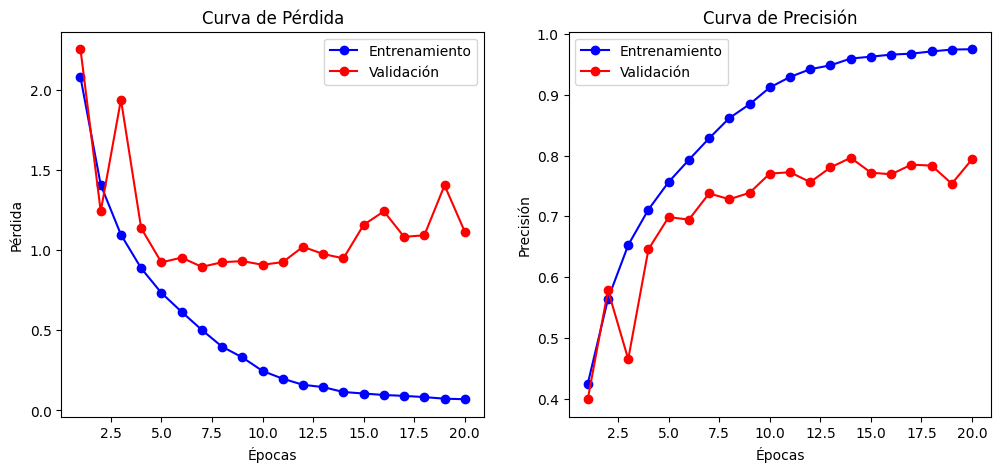

In [29]:
import matplotlib.pyplot as plt

# Extraer datos del historial
loss = history.history['loss']
val_loss = history.history.get('val_loss')
accuracy = history.history.get('accuracy')  # Algunas versiones usan 'acc'
val_accuracy = history.history.get('val_accuracy')  # Algunas usan 'val_acc'

epochs = range(1, len(loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida')
plt.legend()
plt.savefig('curva_perdida.png', dpi=300)  # Guardar en alta resolución

# Graficar la precisión
if accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.title('Curva de Precisión')
    plt.legend()
    plt.savefig('curva_precision.png', dpi=300)

plt.show()


## **Implementación de modelo preentrenado para TensorFlow/Keras**

Ya que TensorFlow no tiene AlexNet preentrenado oficialmente, se optó por utilizar los pesos entrenados proporcionados por el siguiente enlace de la **Universidad de Toronto**: [AlexNet implementation + weights in TensorFlow](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/)

Desde el sitio web se descargó el archivo `bvlc_alexnet.npy` que contiene los pesos de AlexNet y a continuación se cargaron

In [40]:
# Cargar los pesos desde el archivo bvlc_alexnet.npy
weights_dict = np.load("pretrained/bvlc_alexnet.npy", allow_pickle=True, encoding="latin1").item()


### **Asignación de pesos**
Los pesos fueron entrenados en **Caffe** por lo que las dimensiones de los pesos son diferentes a la arquitectura planteada en este trabajo. Esto sucede porque en Caffe, AlexNet fue entrenada con 2 GPUs, lo que dividía los canales en las capas convolucionales.

Ya que Caffe dividía las convoluciones en 2 GPUs, la mitad de los canales estaban en un grupo y la otra mitad en otro. En Keras, necesitamos concatenarlos para formar la arquitectura correcta y a continuación asignamos los pesos a las capas correspondientes.

In [49]:
# 🔹 Definir la arquitectura AlexNet
def build_alexnet():
    model = keras.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4,4), activation='relu', input_shape=(227, 227, 3), name="conv1"),
        layers.MaxPooling2D((3, 3), strides=(2,2), name="pool1"),

        layers.Conv2D(256, (5, 5), padding="same", activation='relu', name="conv2"),
        layers.MaxPooling2D((3, 3), strides=(2,2), name="pool2"),

        layers.Conv2D(384, (3, 3), padding="same", activation='relu', name="conv3"),
        layers.Conv2D(384, (3, 3), padding="same", activation='relu', name="conv4"),
        layers.Conv2D(256, (3, 3), padding="same", activation='relu', name="conv5"),
        layers.MaxPooling2D((3, 3), strides=(2,2), name="pool5"),

        layers.Flatten(),
        layers.Dense(4096, activation='relu', name="fc6"),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu', name="fc7"),
        layers.Dropout(0.5),
        layers.Dense(1000, activation='softmax', name="fc8") # 1000 clases de ImageNet
    ])
    return model

# 🔹 Compilar el modelo
model = build_alexnet()


In [50]:
# Diccionario para mapear nombres de capas de Caffe a Keras
caffe_to_keras = {
    "conv1": "conv1",
    "conv2": "conv2",
    "conv3": "conv3",
    "conv4": "conv4",
    "conv5": "conv5",
    "fc6": "fc6",
    "fc7": "fc7",
    "fc8": "fc8"
}

# Función para combinar los pesos de las capas convolucionales agrupadas
def combine_conv_weights(weights):
    """Combina los pesos de los dos grupos de una capa convolucional de Caffe."""
    kernel = np.concatenate([weights[0], weights[0]], axis=2)
    return [kernel, weights[1]]  # Devolver kernel y bias combinados

# Asignar los pesos cargados usando el mapeo y la combinación
for caffe_layer, keras_layer in caffe_to_keras.items():
    if caffe_layer in weights_dict:
        layer = model.get_layer(keras_layer)
        weights = weights_dict[caffe_layer]

        # Combinar pesos para capas convolucionales agrupadas
        if caffe_layer in ["conv2", "conv4", "conv5"]:
            weights = combine_conv_weights(weights)

        print(f"Forma esperada en {keras_layer}: {layer.get_weights()[0].shape}")
        print(f"Forma de los pesos cargados: {weights[0].shape}")

        layer.set_weights(weights)
        print(f" Pesos cargados en {keras_layer} desde {caffe_layer}")


Forma esperada en conv1: (11, 11, 3, 96)
Forma de los pesos cargados: (11, 11, 3, 96)
 Pesos cargados en conv1 desde conv1
Forma esperada en conv2: (5, 5, 96, 256)
Forma de los pesos cargados: (5, 5, 96, 256)
 Pesos cargados en conv2 desde conv2
Forma esperada en conv3: (3, 3, 256, 384)
Forma de los pesos cargados: (3, 3, 256, 384)
 Pesos cargados en conv3 desde conv3
Forma esperada en conv4: (3, 3, 384, 384)
Forma de los pesos cargados: (3, 3, 384, 384)
 Pesos cargados en conv4 desde conv4
Forma esperada en conv5: (3, 3, 384, 256)
Forma de los pesos cargados: (3, 3, 384, 256)
 Pesos cargados en conv5 desde conv5
Forma esperada en fc6: (9216, 4096)
Forma de los pesos cargados: (9216, 4096)
 Pesos cargados en fc6 desde fc6
Forma esperada en fc7: (4096, 4096)
Forma de los pesos cargados: (4096, 4096)
 Pesos cargados en fc7 desde fc7
Forma esperada en fc8: (4096, 1000)
Forma de los pesos cargados: (4096, 1000)
 Pesos cargados en fc8 desde fc8


In [51]:
# Cargar CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalizar imágenes (0-1)
#x_train = x_train.astype("float32") / 255.0
#x_test = x_test.astype("float32") / 255.0

# Convertir etiquetas a one-hot encoding
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

# 🔹 Crear dataset con resize en tiempo real
def preprocess(image, label):
    image = tf.image.resize(image, (227, 227))  # Redimensionar en tiempo real
    image = image / 255.0  # Normalizar
    image = (image - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.255]
    #image = data_augmentation(image)  # Aplicar data augmentation
    return image, label

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_one_hot))
train_dataset = train_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot))
test_dataset = test_dataset.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

### **Entrenamiento de capas densas**

Ya que AlexNet fue entrenada para clasificación de 1000 clases diferentes, procedemos cambiar la última capa densa que tenga 10 salidas para coincidir con las clases de CIFAR-10 y procedemos a entrenar únicamente las capas densas.

In [52]:
# Cambiar la última capa para 10 clases (CIFAR-10)
model.pop()  # Eliminar la última capa (fc8)
model.add(tf.keras.layers.Dense(10, activation='softmax', name="fc8_cifar10"))

# Congelar todas las capas excepto la última
for layer in model.layers[:-5]:
    layer.trainable = False

# Asegurarse de que la última capa sea entrenable
model.layers[-5].trainable = True

# Recompilar el modelo
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Verificar qué capas están congeladas
for layer in model.layers:
    print(f"Capas: {layer.name}, Entrenable: {layer.trainable}")

# Entrenar el modelo
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Capas: conv1, Entrenable: False
Capas: pool1, Entrenable: False
Capas: conv2, Entrenable: False
Capas: pool2, Entrenable: False
Capas: conv3, Entrenable: False
Capas: conv4, Entrenable: False
Capas: conv5, Entrenable: False
Capas: pool5, Entrenable: False
Capas: flatten_7, Entrenable: False
Capas: fc6, Entrenable: True
Capas: dropout_14, Entrenable: True
Capas: fc7, Entrenable: True
Capas: dropout_15, Entrenable: True
Capas: fc8_cifar10, Entrenable: True
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 150ms/step - accuracy: 0.3855 - loss: 1.7292 - val_accuracy: 0.6294 - val_loss: 1.1084
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 132s 143ms/step - accuracy: 0.5891 - loss: 1.1926 - val_accuracy: 0.6587 - val_loss: 1.0474
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 142ms/step - accuracy: 0.6314 - loss: 1.0873 - val_accuracy: 0.6582 - val_loss: 1.0194
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 110s 141ms/step - accuracy: 0.6507 - loss: 1.0228 - val_accuracy: 0.6666 - val_loss: 0.9963
Epoch 5/10
78

### **Evaluación del Modelo**
El modelo alcanzó una precisión del 70% en el conjunto de prueba de CIFAR-10.


In [1]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

NameError: name 'model' is not defined